---
title: Effect of imaging conditions
---

In [1]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from itertools import product
from functools import reduce

from ipywidgets import Select, SelectMultiple, FloatRangeSlider, Label, Layout

from IPython.display import display
from ipywidgets import HBox, VBox

plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["legend.title_fontsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

In [ ]:
def reduction(series, mode):
    match mode:
        case "mean":
            return series.mean()
        case "min":
            return series.min()
        case "max":
            return series.max()
        case "median":
            return series.median()
        case _:
            return ValueError


def n_image_select():
    return SelectMultiple(
        options=[64, 128, 256, 512],
        value=[64, 128, 256, 512],
        rows=4,
        # description="Number of training images",
        disabled=False,
        layout={"width": "100px", "height":"88px"},
    )


def pretrain_lr_select():
    return SelectMultiple(
        options=["1e-3", "1e-4"],
        value=["1e-3", "1e-4"],
        rows=2,
        # description="Pretrain LRs",
        disabled=False,
        layout={"width": "100px"},
    )


def transfer_lr_select():
    return SelectMultiple(
        options=["1e-4", "1e-5"],
        value=["1e-4", "1e-5"],
        rows=2,
        # description="Transfer LRs",
        disabled=False,
        layout={"width": "100px"},
    )


def weight_freezing_select():
    return SelectMultiple(
        options=["none", "decoder", "encoder"],
        value=["none", "decoder", "encoder"],
        # description="Weight freezing",
        rows=3,
        disabled=False,
        layout={"width": "100px"},
    )


def reduction_select():
    return Select(
        options=["min", "mean", "median", "max"],
        value="mean",
        rows=4,
        # description="Data Reduction",
        disabled=False,
        layout={"width": "100px"},
    )


In [3]:
with open("mini_df.pkl", "rb") as f:
    df = pickle.load(f)

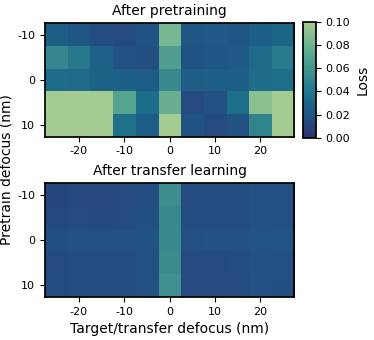

In [ ]:
# | label: app:domain_widget

def get_plot_data(local_df, reduction_mode):
    p_heatmap = np.zeros((5, 11))
    t_heatmap = np.zeros((5, 11))
    common_defoci = [-100, -50, 0, 50, 100]
    all_defoci = np.arange(-250, 300, 50)
    for i, starting_df in enumerate(common_defoci):
        p_df = local_df.query(f"pretrain_defocus == {starting_df}")
        for j, transfer_df in enumerate(all_defoci):
            p_heatmap[i, j] = reduction(
                p_df[f"best_pretrain_val_{transfer_df}"], reduction_mode
            )

            t_df = p_df.query(f"transfer_defocus=={transfer_df}")
            if len(t_df) > 0:
                t_heatmap[i, j] = reduction(
                    t_df[f"best_transfer_performance_{transfer_df}"], reduction_mode
                )
            else:
                t_heatmap[i, j] = p_heatmap[i, j]

    return p_heatmap, t_heatmap


### Get plot data
# p_heatmap, t_heatmap = get_plot_data(df, reduction_mode)

### Figure set up
ratio = 1.1
height = 3.4
fig_style = {
    "figsize": (ratio * height, height),  # inches
    "constrained_layout": True,
}

fig = plt.figure(**fig_style)
gs = fig.add_gridspec(
    4,
    21,
)


ax_p = fig.add_subplot(gs[:2, 1:-1])
ax_t = fig.add_subplot(gs[2:, 1:-1])

# # ax_colorbar = fig.add_axes(
# #     [ax_p.get_position().x1-0.05, ax_p.get_position().y0 - 0.25, 0.05, 0.5]
# )

ax_colorbar = fig.add_subplot(gs[0:2, -1])

cmap = sns.color_palette("crest_r", as_cmap=True)


ndata_select = n_image_select()
ptlr_select = pretrain_lr_select()
tllr_select = transfer_lr_select()
freeze_select = weight_freezing_select()
rmode_select = reduction_select()
prange_select = FloatRangeSlider(
    value=(0.0, 0.1), min=0, max=0.2, step=0.01, layout={'width':'135px'}
)

center_align = Layout(align_items="center")
ptlr_box = VBox([Label("Pretrain LR"), ptlr_select], layout=center_align)
tllr_box = VBox([Label("Transfer LR"), tllr_select], layout=center_align)
ndata_box = VBox([Label("# of transfer images"), ndata_select], layout=center_align)
freeze_box = VBox([Label("Weight Freezing"), freeze_select], layout=center_align)

left_box = VBox([ndata_box, freeze_box], layout={"align_items": "center", "width": "150px"})
right_box = VBox(
    [
        ptlr_box,
        tllr_box,
    ],
    layout={"align_items": "center", "width": "150px"},
)
rmode_box = VBox(
    [
        Label("Reduction Mode"),
        rmode_select,
        Label("Color scale"),
        prange_select,
    ],
    layout={"align_items": "center", "width": "150px"},
)
full_box = HBox([left_box, right_box, rmode_box])

display(full_box)


def update_plot(*args):
    N_points = ndata_select.value
    weight_freezing = freeze_select.value
    pretrain_lrs = ptlr_select.value
    transfer_lrs = tllr_select.value
    reduction_mode = rmode_select.value

    active_lr_pairs = tuple(product(pretrain_lrs, transfer_lrs))
    lr_query = reduce(
        lambda x, y: f"{x} or {y}",
        (f"(pretrain_lr == {x} and transfer_lr == {y})" for x, y in active_lr_pairs),
    )

    plot_df = df.query(
        f"N_tl_training_points in {N_points} and freeze_option in {weight_freezing}"
    ).query(lr_query)

    p_heatmap, t_heatmap = get_plot_data(plot_df, reduction_mode)
    pmin = prange_select.value[0]
    pmax = prange_select.value[1]

    cim = ax_p.matshow(p_heatmap, cmap=cmap, vmin=pmin, vmax=pmax)
    ax_t.matshow(t_heatmap, cmap=cmap, vmin=pmin, vmax=pmax)
    ax_p.set_xticks([])

    ax_colorbar.clear()
    fig.colorbar(cim, cax=ax_colorbar)
    ax_colorbar.set_ylabel("Loss", fontsize=10)
    ax_colorbar.tick_params(labelsize=8)

    for ax in [ax_p, ax_t]:
        ax.set_yticks([0, 2, 4])
        ax.set_yticklabels([-10, 0, 10], fontsize=8)
        ax.set_xticks([1, 3, 5, 7, 9])
        ax.set_xticklabels([-20, -10, 0, 10, 20], rotation=0, fontsize=8)
        ax.xaxis.set_ticks_position("bottom")

    fig.supylabel("Pretrain defocus (nm)", fontsize=10, x=-0.0)

    _ = [plt.setp(ax.spines.values(), linewidth=1.25) for ax in (ax_p, ax_t, ax_colorbar)]

    ax_p.set_title("After pretraining", fontsize=10)
    ax_t.set_title("After transfer learning", fontsize=10)
    ax_t.set_xlabel("Target/transfer defocus (nm)", fontsize=10)


update_plot()
ndata_select.observe(update_plot, "value")
ptlr_select.observe(update_plot, "value")
tllr_select.observe(update_plot, "value")
rmode_select.observe(update_plot, "value")
freeze_select.observe(update_plot, "value")
prange_select.observe(
    update_plot, "value"
)  # This can be made faster to avoid re-querying the dataframe